# Model training
This notebook consists of 4 parts:

1. Connecting to the Feature Store
2. Creating training data with the newest data in the "historic" feature views
3. Training models for each parking spot
4. Uploading/updating models and their performance in the Feature Store and Github

In [1]:
# Standard library imports
import os
import shutil
import joblib

# Data handling and analysis
import pandas as pd

# Visualization libraries
from matplotlib import pyplot
import seaborn as sns

# Machine Learning: model and metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Hopsworks-related imports
import hopsworks
from hsml.schema import Schema
from hsml.model_schema import ModelSchema


## 1. Connecting to the Feature Store

In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Multiple projects found. 

	 (1) annikaij
	 (2) miknie20

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/549019
Connected. Call `.close()` to terminate connection gracefully.


## 2. Train, test and evaluate model for building data

In [3]:
# Get the latest version of the feature view
version=1
feature_view = fs.get_feature_view("building_hist_fv", version=version)

In [4]:
# Get the latest version of the training dataset
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.51s) 
2024-05-08 14:11:45,912 WARNING: VersionWarning: Incremented version to `1`.



In [5]:
# Check the distribution of the target variable
y_train.value_counts(normalize=True)

mag_cluster 
no_detection    0.919637
detection       0.080363
Name: proportion, dtype: float64

In [6]:
# Define the model
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

In [7]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred

array(['no_detection', 'no_detection', 'no_detection', ...,
       'no_detection', 'no_detection', 'no_detection'], dtype=object)

In [8]:
# make classification report
metrics = classification_report(y_test, y_pred, output_dict=True)
metrics

{'detection': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 122.0},
 'no_detection': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 1309.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 1431.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 1431.0}}

In [9]:
# save the results in the model schema
results = confusion_matrix(y_test, y_pred)

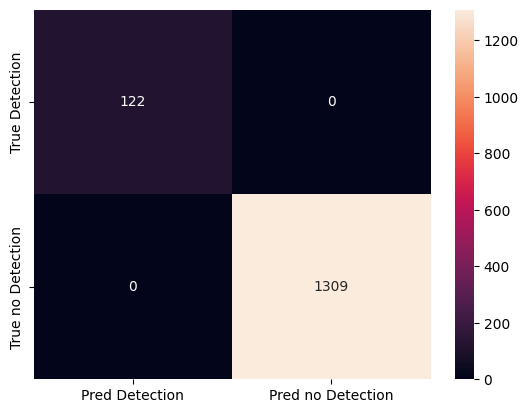

In [12]:
# Make and save the confusion matrix
df_cm = pd.DataFrame(results, ['True Detection', 'True no Detection'],
                     ['Pred Detection', 'Pred no Detection'])

cm = sns.heatmap(df_cm, annot=True, fmt='g')

fig = cm.get_figure()
fig.savefig("/work/Test_MLOps_Project/pictures/building_hist_confusion_matrix.png") 
fig.show()

## 2. Train, test and evaluate model for bike lane data

In [13]:
# Getting the bikelane_hist_fv feature view
version=1
bikelane_feature_view = fs.get_feature_view("bikelane_hist_fv", version=version)

In [14]:
# Get the latest version of the training dataset
t_X_train, t_X_test, t_y_train, t_y_test = bikelane_feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.47s) 
2024-05-08 14:12:44,179 WARNING: VersionWarning: Incremented version to `1`.



In [15]:
# Check the distribution of the target variable
t_y_train.value_counts(normalize=True)

mag_cluster 
no_detection    0.965407
detection       0.034593
Name: proportion, dtype: float64

In [16]:
# Define the model
t_model = KNeighborsClassifier(n_neighbors=2)
t_model.fit(t_X_train, t_y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

In [17]:
# Make predictions on the test set
t_y_pred = t_model.predict(t_X_test)
t_y_pred

array(['no_detection', 'no_detection', 'no_detection', ...,
       'no_detection', 'no_detection', 'no_detection'], dtype=object)

In [18]:
# Make classification report
t_metrics = classification_report(t_y_test, t_y_pred, output_dict=True)
t_metrics

{'detection': {'precision': 0.9830508474576272,
  'recall': 1.0,
  'f1-score': 0.9914529914529915,
  'support': 58.0},
 'no_detection': {'precision': 1.0,
  'recall': 0.9992603550295858,
  'f1-score': 0.9996300406955235,
  'support': 1352.0},
 'accuracy': 0.999290780141844,
 'macro avg': {'precision': 0.9915254237288136,
  'recall': 0.9996301775147929,
  'f1-score': 0.9955415160742576,
  'support': 1410.0},
 'weighted avg': {'precision': 0.999302800817406,
  'recall': 0.999290780141844,
  'f1-score': 0.999293679804696,
  'support': 1410.0}}

In [19]:
# Save the results in the model schema
t_results = confusion_matrix(t_y_test, t_y_pred)
t_results

array([[  58,    0],
       [   1, 1351]])

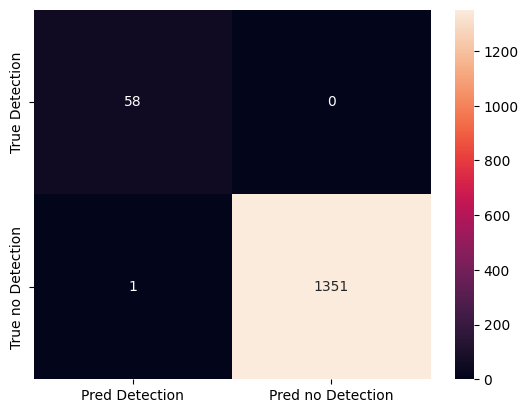

In [21]:
# Make and save the confusion matrix
t_df_cm = pd.DataFrame(t_results, ['True Detection', 'True no Detection'],
                     ['Pred Detection', 'Pred no Detection'])

t_cm = sns.heatmap(t_df_cm, annot=True, fmt='g')

fig = t_cm.get_figure()
fig.savefig("/work/Test_MLOps_Project/pictures/bikelane_hist_confusion_matrix.png") 
fig.show()

## 4. Uploading/updating models in the Feature Store

In [22]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [24]:

model_dir="models"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
joblib.dump(model, model_dir + "/building_hist_model.pkl")
shutil.copyfile("/work/Test_MLOps_Project/pictures/building_hist_confusion_matrix.png", model_dir + "/building_hist_confusion_matrix.png")

input_example = X_train.sample()
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

building_hist_model = mr.python.create_model(
    version=2,
    name="building_hist_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example, 
    description="Predictions on the parking spot close to the building",)

building_hist_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/388710 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/383142 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18129 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19100 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1136998 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1136998 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18826 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18784 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/23 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/378 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/549019/models/building_hist_model/2


Model(name: 'building_hist_model', version: 2)

In [25]:

if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
joblib.dump(t_model, model_dir + "/bikelane_hist_model.pkl")
shutil.copyfile("/work/Test_MLOps_Project/pictures/bikelane_hist_confusion_matrix.png", model_dir + "/bikelane_hist_confusion_matrix.png")

input_example = t_X_train.sample()
input_schema = Schema(t_X_train)
output_schema = Schema(t_y_train)
model_schema = ModelSchema(input_schema, output_schema)

bikelane_hist_model = mr.python.create_model(
    version=1,
    name="bikelane_hist_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example, 
    description="Predictions on the parking spot close to the bikelane",)

bikelane_hist_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/388710 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/383142 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18129 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19100 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1136998 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1136998 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18868 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18784 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/23 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/378 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/549019/models/bikelane_hist_model/1


Model(name: 'bikelane_hist_model', version: 1)

## **Next up:** 5: Inference pipeline
Go to the 5_inference_pipeline.ipynb notebook